In [1]:
import numpy as np
import tensorflow as tf
import re
import keras  
import os
import glob 
from skimage import io 
import skimage
import random 
import matplotlib.pyplot as plt  
import cv2
from os import listdir
from os.path import isfile, join
from PIL import Image 
import pandas as pd
import joblib
%matplotlib inline

In [4]:
data_path = 'data/archive/cat_dog_images'
labels_path = 'data/archive/cat_dog.csv'

## Explorando os Dados

### Carregando as imagens

In [3]:
mypath= data_path
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
cat_dog_images = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  cat_dog_images[n] = cv2.imread(join(mypath,onlyfiles[n]))
  cat_dog_images[n] = cv2.cvtColor(cat_dog_images[n], cv2.COLOR_BGR2RGB)

In [4]:
cat_dog_images.shape

(25000,)

In [63]:
joblib.dump(cat_dog_images, "cat_dog_images_features.pkl")

['cat_dog_images_features.pkl']

### Exemplo de imagens:

Text(0.5, 1.0, 'A dog')

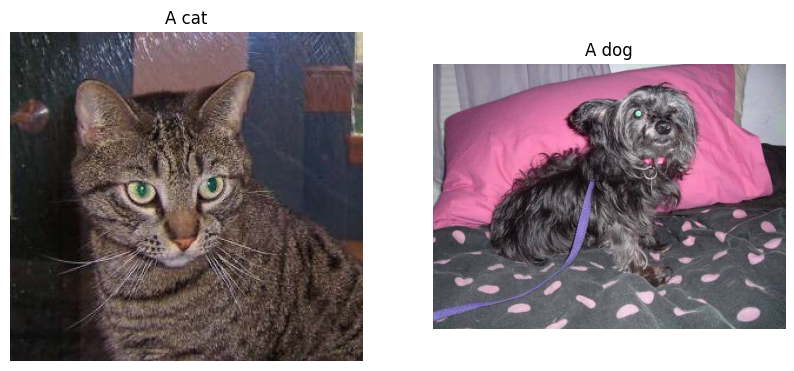

In [5]:
cat = cat_dog_images[1]
dog = cat_dog_images[12500]
rows =1
columns =2
fig = plt.figure(figsize=(10, 7)) 
fig.add_subplot(rows, columns, 1)

plt.imshow(cat) 
plt.axis('off') 
plt.title("A cat")

fig.add_subplot(rows, columns, 2) 
plt.imshow(dog)
plt.axis('off')
plt.title("A dog")

### Carregando labels:

In [2]:
def extract_numbers(input_values): 
    return ''.join(re.findall(r'\d', input_values))

In [5]:
labels = pd.read_csv(labels_path)
image_numbers = labels['image'].values
image_numbers = np.vectorize(extract_numbers)(image_numbers).astype(int)
image_numbers = pd.DataFrame(image_numbers)
image_numbers.rename(columns={0 : "image index"}, inplace=True)
labels['species'] = labels['labels'].apply(lambda x: 'dog' if x == 1 else 'cat')
labels = pd.concat([image_numbers,labels],axis =1)
labels.sort_values(by=["species", "image index"], inplace=True)
labels

,image index,image,labels,species
9081,0,cat.0.jpg,0,cat
5265,1,cat.1.jpg,0,cat
15409,2,cat.2.jpg,0,cat
19172,3,cat.3.jpg,0,cat
15863,4,cat.4.jpg,0,cat
...,...,...,...,...
5451,12495,dog.12495.jpg,1,dog
4856,12496,dog.12496.jpg,1,dog
18541,12497,dog.12497.jpg,1,dog
16279,12498,dog.12498.jpg,1,dog


### Analisando os canais RGB e a imagem original

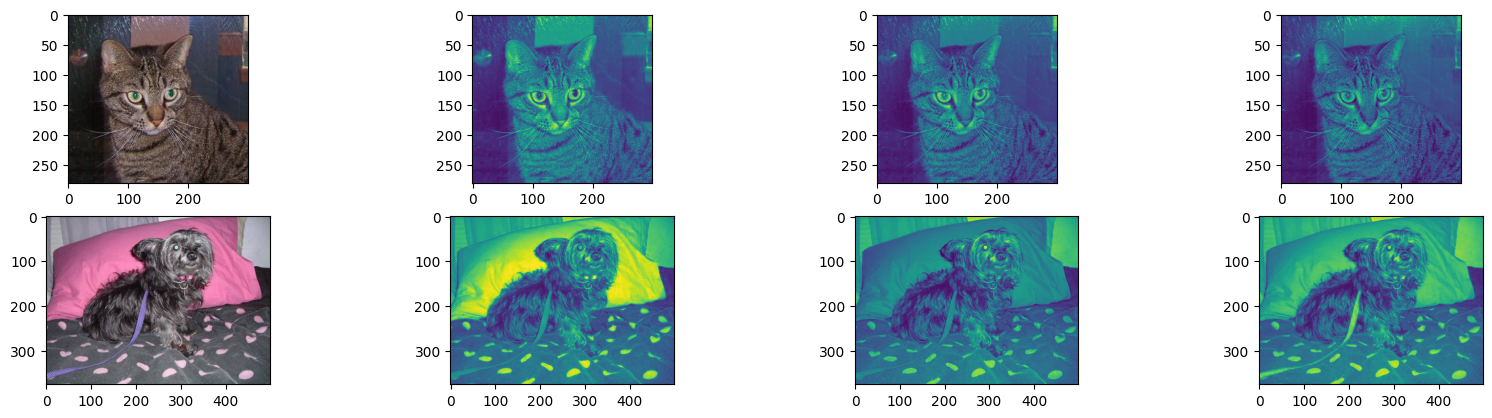

In [8]:
i, ((im1, im2, im3, im4), (im5, im6, im7, im8)) = plt.subplots(2, 4, sharey=False)
i.set_figwidth(20) 
im1.imshow(cat) 
im2.imshow(cat[:, : , 0]) #Red
im3.imshow(cat[:, : , 1]) #Green
im4.imshow(cat[:, : , 2]) #Blue
im5.imshow(dog) 
im6.imshow(dog[:, : , 0]) #Red
im7.imshow(dog[:, : , 1]) #Green
im8.imshow(dog[:, : , 2]) #Blue

## Pré-processamento das imagens

In [10]:
animal_targets = labels['labels'].to_numpy()
print("animal targets: ",animal_targets)

animal targets:  [0 0 0 ... 1 1 1]


### Redimensionando as imagens:

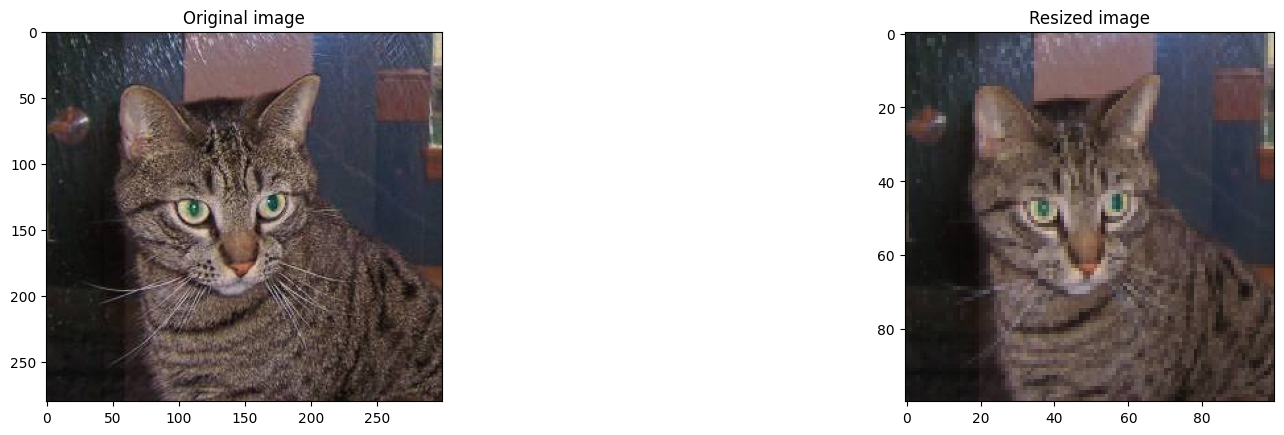

In [10]:
cat_resized = skimage.transform.resize(cat, (100, 100), anti_aliasing=True)
i, (im1, im2) = plt.subplots(1, 2, sharey=False)
i.set_figwidth(20)
im1.imshow(cat)
im1.title.set_text("Original image")
im2.imshow(cat_resized)
im2.title.set_text("Resized image")

In [11]:
for i in range(cat_dog_images.shape[0]):
    cat_dog_images[i] = skimage.transform.resize(cat_dog_images[i], (100, 100), anti_aliasing=True)

### Convertendo canais de cor para escala de cinza:

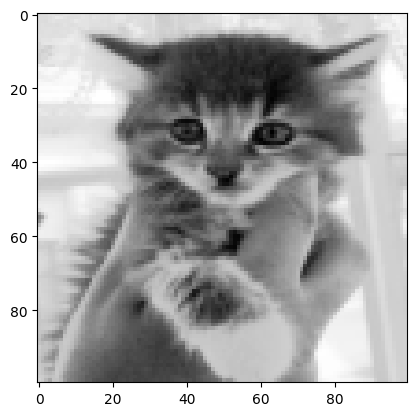

In [12]:
gray_cat = skimage.color.rgb2gray(cat_dog_images[3])
i, (im1) = plt.subplots(1, 1, sharey=False)
i.set_figwidth(20) 
im1.imshow(gray_cat, cmap='gray')

In [13]:
for i in range(cat_dog_images.shape[0]):
    cat_dog_images[i] = skimage.color.rgb2gray(cat_dog_images[i])

### Achatando imagens para a entrada do treinamento do modelo 

In [7]:
cat_dog_images = joblib.load('cat_dog_images_features.pkl')

In [8]:
cat_array_reshape = cat_dog_images[0]
shape = cat_array_reshape.shape[0] * cat_array_reshape.shape[1]
cat_dog_images_reshaped = np.squeeze(np.array([image.reshape(shape, 1) for image in cat_dog_images]))
cat_dog_images_reshaped.shape

(25000, 10000)

### Separando conjunto de treinamento e de testes

In [11]:
X = cat_dog_images_reshaped
y = animal_targets

In [12]:
print("X shape: ", X.shape, "y shape: ", y.shape)

X shape:  (25000, 10000) y shape:  (25000,)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Carregando os Modelos:

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

dec_tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
sgd_clf = SGDClassifier(random_state=42)

In [22]:
mlp_clf = MLPClassifier(max_iter=500, hidden_layer_sizes=(30,40,30), verbose=1, random_state=42)

In [18]:
from sklearn.metrics import f1_score,  precision_score, recall_score

def model_rounds(X_train, y_train, X_test, y_test, model):
    f1 = []
    precision = []
    recall = []
    for _ in range(15):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score =  f1_score(y_true=y_test, y_pred = y_pred)
        f1.append(score)
        score = precision_score(y_true=y_test, y_pred = y_pred)
        precision.append(score)
        score = recall_score(y_true=y_test, y_pred = y_pred)
        recall.append(score)
    return np.array(f1),np.array(precision),np.array(recall)

## Treinando os Modelos:

In [19]:
dec_tree_f1_score, dec_tree_precision_score, dec_tree_recall_score = model_rounds(X_train, y_train, X_test, y_test, dec_tree_clf)

In [20]:
sgd_clf_f1_score, sgd_clf_precision_score, sgd_clf_recall_score = model_rounds(X_train, y_train, X_test, y_test, sgd_clf)

In [25]:
mlp_clf_f1_score, mlp_clf_precision_score, mlp_clf_recall_score = model_rounds(X_train, y_train, X_test, y_test, mlp_clf)

Iteration 1, loss = 0.73452343
Iteration 2, loss = 0.69042494
Iteration 3, loss = 0.65705417
Iteration 4, loss = 0.63377863
Iteration 5, loss = 0.62496561
Iteration 6, loss = 0.59989942
Iteration 7, loss = 0.57809540
Iteration 8, loss = 0.56412836
Iteration 9, loss = 0.54228332
Iteration 10, loss = 0.52513587
Iteration 11, loss = 0.50629249
Iteration 12, loss = 0.48990915
Iteration 13, loss = 0.47492576
Iteration 14, loss = 0.45933530
Iteration 15, loss = 0.43575737
Iteration 16, loss = 0.42402388
Iteration 17, loss = 0.40012620
Iteration 18, loss = 0.37986280
Iteration 19, loss = 0.36731897
Iteration 20, loss = 0.35093565
Iteration 21, loss = 0.33274872
Iteration 22, loss = 0.31860017
Iteration 23, loss = 0.29874456
Iteration 24, loss = 0.28653846
Iteration 25, loss = 0.27573449
Iteration 26, loss = 0.25635293
Iteration 27, loss = 0.24957395
Iteration 28, loss = 0.22999416
Iteration 29, loss = 0.22194206
Iteration 30, loss = 0.21170259
Iteration 31, loss = 0.19137982
Iteration 32, los

### Armazenando resultados e modelos:

In [23]:
joblib.dump(dec_tree_clf, "dec_tree_clf.pkl")
joblib.dump(dec_tree_f1_score, "dec_tree_f1_score.pkl")
joblib.dump(dec_tree_precision_score, "dec_tree_precision_score.pkl")
joblib.dump(dec_tree_recall_score, "dec_tree_recall_score.pkl")

['dec_tree_recall_score.pkl']

In [24]:
joblib.dump(sgd_clf, "sgd_clf_clf.pkl")
joblib.dump(sgd_clf_f1_score, "sgd_clf_f1_score.pkl")
joblib.dump(sgd_clf_precision_score, "sgd_clf_precision_score.pkl")
joblib.dump(sgd_clf_recall_score, "sgd_clf_recall_score.pkl")

['sgd_clf_recall_score.pkl']

In [26]:
joblib.dump(mlp_clf, "mlp_clf_clf.pkl")
joblib.dump(mlp_clf_f1_score, "mlp_clf_f1_score.pkl")
joblib.dump(mlp_clf_precision_score, "mlp_clf_precision_score.pkl")
joblib.dump(mlp_clf_recall_score, "mlp_clf_recall_score.pkl")

['mlp_clf_recall_score.pkl']

## Resultados:

In [28]:
sgd_results = pd.DataFrame({
    'SGD F1': sgd_clf_f1_score,
    'SGD Precision': sgd_clf_precision_score,
    'SGD Recall': sgd_clf_recall_score
})

dec_tree_results = pd.DataFrame({
    'Decision Tree F1': dec_tree_f1_score,
    'Decision Tree Precision': dec_tree_precision_score,
    'Decision Tree Recall': dec_tree_recall_score
})

mlp_clf_results = pd.DataFrame({
    'Multi Layer Perceptron F1': mlp_clf_f1_score,
    'Multi Layer Perceptron Precision': mlp_clf_precision_score,
    'Multi Layer Perceptron Recall': mlp_clf_recall_score
})

In [29]:
joblib.dump(sgd_results, "sgd_results.pkl")
joblib.dump(dec_tree_results, "dec_tree_results.pkl")
joblib.dump(mlp_clf_results, "mlp_results.pkl")

['mlp_results.pkl']

In [30]:
results = pd.concat([sgd_results,dec_tree_results,mlp_clf_results], axis=1)
results

,SGD F1,SGD Precision,SGD Recall,Decision Tree F1,Decision Tree Precision,Decision Tree Recall,Multi Layer Perceptron F1,Multi Layer Perceptron Precision,Multi Layer Perceptron Recall
0,0.502598,0.519776,0.486519,0.60912,0.570675,0.653119,0.580672,0.603209,0.559759
1,0.502598,0.519776,0.486519,0.60912,0.570675,0.653119,0.580672,0.603209,0.559759
2,0.502598,0.519776,0.486519,0.60912,0.570675,0.653119,0.580672,0.603209,0.559759
3,0.502598,0.519776,0.486519,0.60912,0.570675,0.653119,0.580672,0.603209,0.559759
4,0.502598,0.519776,0.486519,0.60912,0.570675,0.653119,0.580672,0.603209,0.559759
5,0.502598,0.519776,0.486519,0.60912,0.570675,0.653119,0.580672,0.603209,0.559759
6,0.502598,0.519776,0.486519,0.60912,0.570675,0.653119,0.580672,0.603209,0.559759
7,0.502598,0.519776,0.486519,0.60912,0.570675,0.653119,0.580672,0.603209,0.559759
8,0.502598,0.519776,0.486519,0.60912,0.570675,0.653119,0.580672,0.603209,0.559759
9,0.502598,0.519776,0.486519,0.60912,0.570675,0.653119,0.580672,0.603209,0.559759


In [31]:
joblib.dump(results, "total_results.pkl")

['total_results.pkl']

### Média e Desvio Padrão:

In [32]:
mean_cat_dog = results.mean()
std_cat_dog = results.mean()

In [33]:
mean_cat_dog

SGD F1                              0.502598
SGD Precision                       0.519776
SGD Recall                          0.486519
Decision Tree F1                    0.609120
Decision Tree Precision             0.570675
Decision Tree Recall                0.653119
Multi Layer Perceptron F1           0.580672
Multi Layer Perceptron Precision    0.603209
Multi Layer Perceptron Recall       0.559759
dtype: float64

In [34]:
std_cat_dog

SGD F1                              0.502598
SGD Precision                       0.519776
SGD Recall                          0.486519
Decision Tree F1                    0.609120
Decision Tree Precision             0.570675
Decision Tree Recall                0.653119
Multi Layer Perceptron F1           0.580672
Multi Layer Perceptron Precision    0.603209
Multi Layer Perceptron Recall       0.559759
dtype: float64

### Boxplot dos dados:

### Gradiente Descendente:

<Axes: >

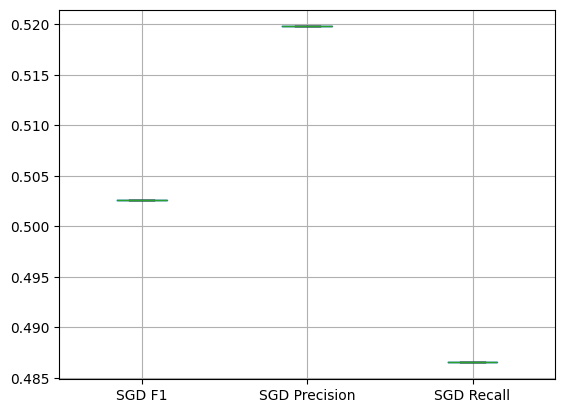

In [35]:
sgd_results.boxplot()

### Árvore de Decisão:

<Axes: >

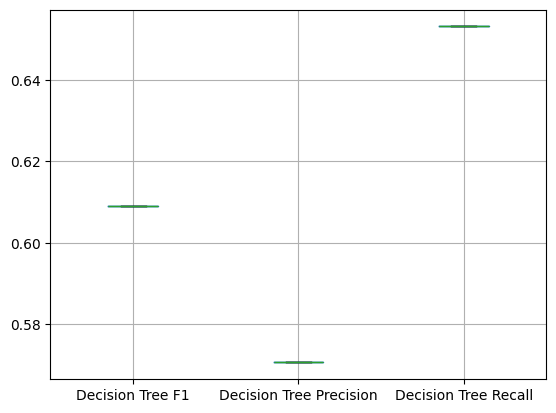

In [36]:
dec_tree_results.boxplot()

### Multi Layer Perceptron:

<Axes: >

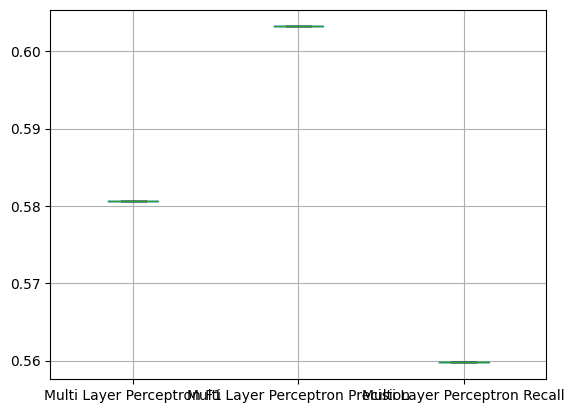

In [37]:
mlp_clf_results.boxplot()